In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.signal

from datetime import date
import time

from random import seed
from random import random

import os, os.path
import shutil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib
import matplotlib.pyplot as plt
from pylab import imshow

import h5py
import sys
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
# import NASA_plot_core.py as rcp

# Do the digits to make sure things work

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

In [3]:
# Print to show there are 1797 images (8 by 8 images for a dimensionality of 64)
print("Image Data Shape" , digits.data.shape)
# Print to show there are 1797 labels (integers from 0–9)
print("Label Data Shape", digits.target.shape)

Image Data Shape (1797, 64)
Label Data Shape (1797,)


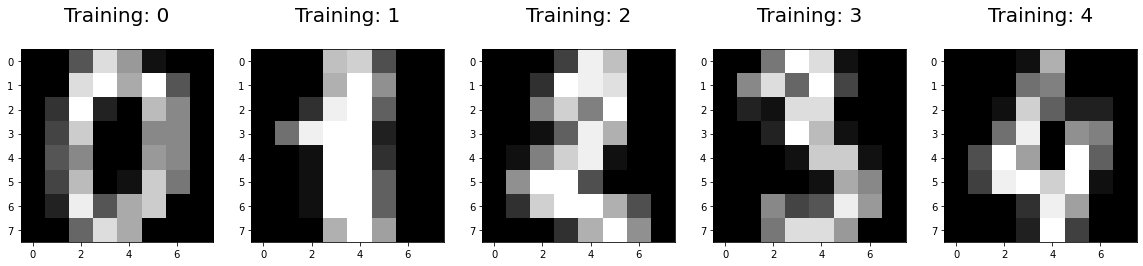

In [4]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1) # 1 row, 5 columns, 
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Split dataset

In [86]:
# split the train and test set randomly
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, 
                                                    test_size=0.25, 
                                                    random_state=0, 
                                                    shuffle=True,
                                                    stratify=digits.target)

In [6]:
# Make an instance of the Model
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(max_iter=100000)
logisticRegr.fit(x_train, y_train)

prediction is [2].


Text(0.5, 1.0, 'Actual image of the Test: 2\n')

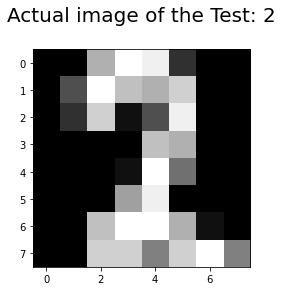

In [8]:
# Returns a NumPy Array
# Predict for One Observation (image)
test_index = 0

prediction = logisticRegr.predict(x_test[test_index].reshape(1,-1))
print ("prediction is {}.".format(prediction))

plt.subplot(1, 1, 1) # 1 row, 5 columns, 
plt.imshow(np.reshape(x_test[0], (8,8)), cmap=plt.cm.gray)
plt.title('Actual image of the Test: %i\n' % y_test[test_index], fontsize = 20)

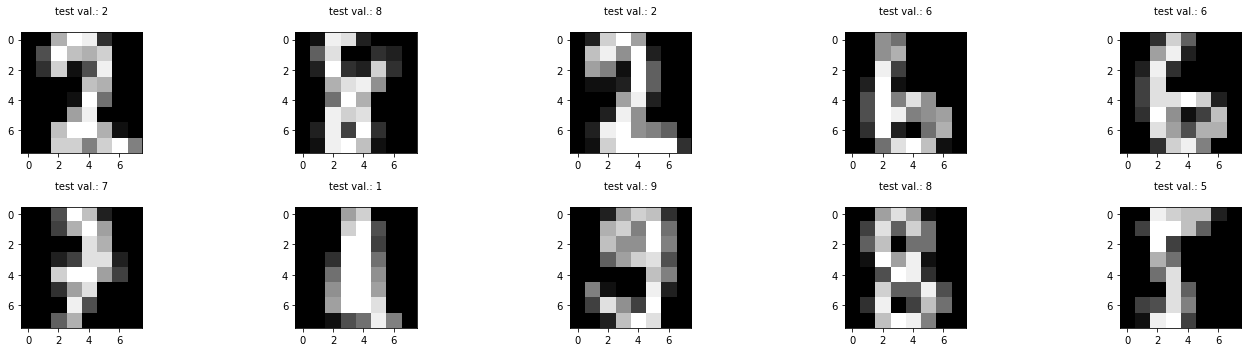

In [9]:
multiple_test_size = 10
logisticRegr.predict(x_test[0:multiple_test_size])

plt.figure(figsize=(20,5))
n_cols = 5
n_rows = -(multiple_test_size // -n_cols)
for index, (image, label) in enumerate(zip(x_test[0:multiple_test_size], y_test[0:multiple_test_size])):
    plt.subplot(n_rows, n_cols, index + 1) # 1 row, 5 columns, 
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('test val.: %i\n' % label, fontsize = 10)
    
plt.tight_layout()

In [10]:
# plt.figure(figsize=(20,4))
# for i in range(1, 7):
#     plt.subplot(2, 3, i)
#     plt.text(0.5, 0.5, str((2, 3, i)), fontsize=18, ha='center')

# Read Training Set Labels

In [22]:
training_set_dir = "/Users/hn/Documents/01_research_data/NASA/ML_data/"
train_labels = pd.read_csv(training_set_dir+"train_labels.csv")
print ("Unique Votes: ", train_labels.Vote.unique())
print (len(train_labels.ID.unique()))
train_labels.head(2)

Unique Votes:  [2 1]
434


,ID,Vote
0,99837_WSDA_SF_2017,2
1,114615_WSDA_SF_2017,1


# Start VI images

In [12]:
interval_size=10
no_data = 365//10

In [13]:
idx = "EVI"
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/05_SG_TS/"

In [14]:
file_names = ["SG_Walla2015_EVI_JFD.csv", "SG_AdamBenton2016_EVI_JFD.csv", 
              "SG_Grant2017_EVI_JFD.csv", "SG_FranklinYakima2018_EVI_JFD.csv"]

data=pd.DataFrame()

for file in file_names:
    curr_file=pd.read_csv(data_dir + file)
    curr_file['human_system_start_time'] = pd.to_datetime(curr_file['human_system_start_time'])
    
    # These data are for 3 years. The middle one is the correct one
    all_years = sorted(curr_file.human_system_start_time.dt.year.unique())
    if len(all_years)==3 or len(all_years)==2:
        proper_year = all_years[1]
    elif len(all_years)==1:
        proper_year = all_years[0]

    curr_file = curr_file[curr_file.human_system_start_time.dt.year==proper_year]
    data=pd.concat([data, curr_file])

data.reset_index(drop=True, inplace=True)
data.head(2)

,ID,human_system_start_time,EVI
0,135073_WSDA_SF_2015,2015-01-10,0.054429
1,135073_WSDA_SF_2015,2015-01-20,0.051731


In [15]:
train_df = data[data.ID.isin(list(train_labels.ID.unique()))].copy()

# Sort the order of time-series and experts' labels identically

In [236]:
train_df.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
train_labels.sort_values(by=["ID"], inplace=True)

train_df.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)

In [237]:
assert (len(train_df.ID.unique()) == len(train_labels.ID.unique()))

In [238]:
print (list(train_df.ID)[0])
print (list(train_labels.ID)[0])
print ("____________________________________")
print (list(train_df.ID)[-1])
print (list(train_labels.ID)[-1])
print ("____________________________________")
print (list(train_df.ID.unique())==list(train_labels.ID.unique()))

100658_WSDA_SF_2017
100658_WSDA_SF_2017
____________________________________
99868_WSDA_SF_2017
99868_WSDA_SF_2017
____________________________________
True


# Convert the dataframe to numpy array 2D

In [239]:
TS_array = np.zeros((len(train_df.ID.unique()), 36))
for count, ID in enumerate(train_df.ID.unique()):
    TS_array[count] = train_df[train_df.ID==ID][idx].values[:36]

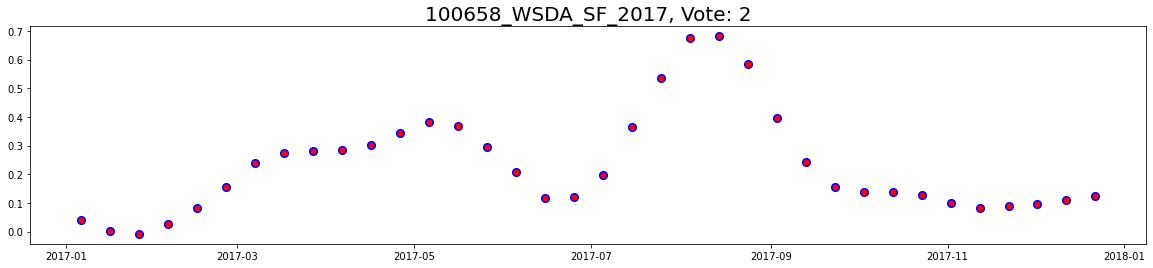

In [240]:
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

field_number = 0
plt.scatter(train_df[train_df.ID==train_df.ID.unique()[field_number]]["human_system_start_time"].values[:36],
            train_df[train_df.ID==train_df.ID.unique()[field_number]][idx].values[:36],
            marker='o', s=65, c='b', label=idx);

plt.scatter(train_df[train_df.ID==train_df.ID.unique()[field_number]]["human_system_start_time"].values[:36],
            TS_array[0], 
            marker='o', s=25, c='r', label=idx);

vote = str(train_labels[train_labels.ID==train_df.ID.unique()[field_number]]['Vote'].values[0])
title = train_df.ID.unique()[field_number] + ", " + "Vote: " + vote
plt.title(title , fontsize = 20);

# Split Train and Test Set

In [241]:
# split the train and test set randomly
x_train, x_test, y_train, y_test = train_test_split(TS_array, train_labels.Vote.values, 
                                                    test_size=0.25, 
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=train_labels.Vote.values)

In [242]:
# Make an instance of the Model
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(max_iter=100000)
logisticRegr.fit(x_train, y_train)

LogisticRegression(max_iter=100000)

prediction is [1].


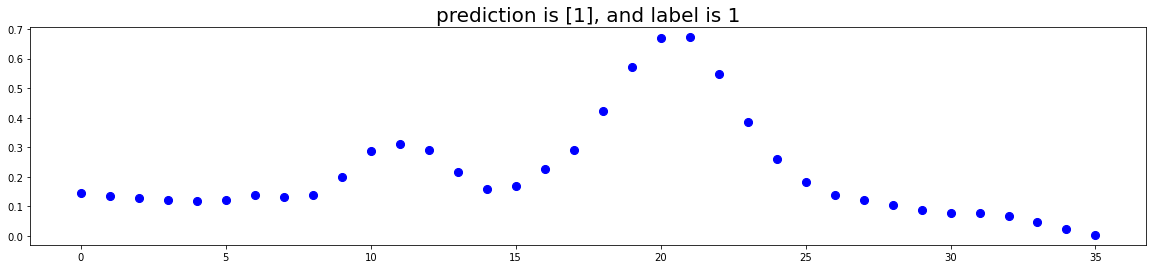

In [243]:
# Returns a NumPy Array
# Predict for One Observation (image)
test_index = 0
prediction = logisticRegr.predict(x_test[test_index].reshape(1,-1))
print ("prediction is {}.".format(prediction))

######################################################
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

field_number = 0
plt.scatter(range(len(x_test[test_index])),
            x_test[test_index],
            marker='o', s=65, c='b', label=idx);


title = "prediction is " + str(prediction) + ", and label is " + str(y_test[test_index])
plt.title(title , fontsize = 20);


In [244]:
y_test[test_index]

1

# Logistic Regression with Pandas

I want to split pandas dataframes so that we have access to IDs easily.

In [245]:
EVI_colnames = [idx + "_" + str(ii) for ii in range(1, 37) ]
columnNames = ["ID"] + EVI_colnames
train_df_wide = pd.DataFrame(columns=columnNames, 
                             index=range(len(train_df.ID.unique())))
train_df_wide["ID"] = train_df.ID.unique()

In [246]:
for an_ID in train_df.ID.unique():
    curr_df = train_df[train_df.ID==an_ID]
    
    train_df_wide_indx = train_df_wide[train_df_wide.ID==an_ID].index
    train_df_wide.loc[train_df_wide_indx, "EVI_1":"EVI_36"] = curr_df.EVI.values[:36]

In [247]:
train_df_wide.head(2)

,ID,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,...,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33,EVI_34,EVI_35,EVI_36
0,100658_WSDA_SF_2017,0.039378,0.003539,-0.008009,0.025816,0.081537,0.156433,0.239957,0.27463,0.282809,...,0.155738,0.138827,0.136556,0.127832,0.09996,0.082512,0.088335,0.095237,0.108741,0.125825
1,100661_WSDA_SF_2017,0.0,0.0,-0.003635,-0.000627,0.008302,0.034272,0.068471,0.109112,0.157214,...,0.131337,0.194901,0.291371,0.365691,0.404244,0.439063,0.458254,0.481119,0.470967,0.445632


In [248]:
train_df.head(2)

,ID,human_system_start_time,EVI
0,100658_WSDA_SF_2017,2017-01-06,0.039378
1,100658_WSDA_SF_2017,2017-01-16,0.003539


In [249]:
train_labels.head(2)

,ID,Vote
0,100658_WSDA_SF_2017,2
1,100661_WSDA_SF_2017,1


# Check if we did the right things:

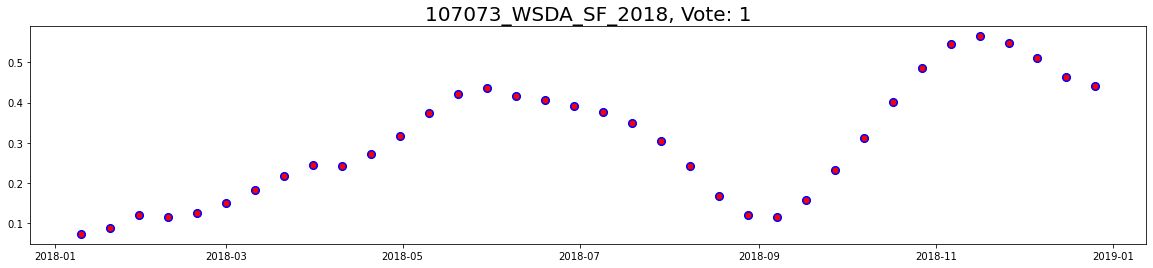

In [250]:
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

field_number = 120
ID = train_df.ID.unique()[field_number]
plt.scatter(train_df[train_df.ID==ID]["human_system_start_time"].values[:36],
            train_df[train_df.ID==ID][idx].values[:36],
            marker='o', s=65, c='b', label=idx);

plt.scatter(train_df[train_df.ID==ID]["human_system_start_time"].values[:36],
            train_df_wide[train_df_wide.ID==ID].values[0][1:],
            marker='o', s=25, c='r', label=idx);

vote = str(train_labels[train_labels.ID==train_df.ID.unique()[field_number]]['Vote'].values[0])
title = train_df.ID.unique()[field_number] + ", " + "Vote: " + vote
plt.title(title , fontsize = 20);

In [251]:
len(train_df_wide.ID.unique())==len(train_labels.ID.unique())

True

In [252]:
train_df.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
train_labels.sort_values(by=["ID"], inplace=True)

train_df.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)

In [253]:
train_df_wide.head(2)

,ID,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,...,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33,EVI_34,EVI_35,EVI_36
0,100658_WSDA_SF_2017,0.039378,0.003539,-0.008009,0.025816,0.081537,0.156433,0.239957,0.27463,0.282809,...,0.155738,0.138827,0.136556,0.127832,0.09996,0.082512,0.088335,0.095237,0.108741,0.125825
1,100661_WSDA_SF_2017,0.0,0.0,-0.003635,-0.000627,0.008302,0.034272,0.068471,0.109112,0.157214,...,0.131337,0.194901,0.291371,0.365691,0.404244,0.439063,0.458254,0.481119,0.470967,0.445632


In [254]:
train_labels.head(2)

,ID,Vote
0,100658_WSDA_SF_2017,2
1,100661_WSDA_SF_2017,1


In [255]:
# split the train and test set randomly
# split the train and test set randomly
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(train_df_wide, 
                                                                train_labels, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                shuffle=True,
                                                                stratify=train_labels.Vote.values)

In [256]:
# Make an instance of the Model
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression();
logisticRegr.fit(x_train_df.loc[:, "EVI_1":"EVI_36"], y_train_df.Vote.values);

prediction is [2].


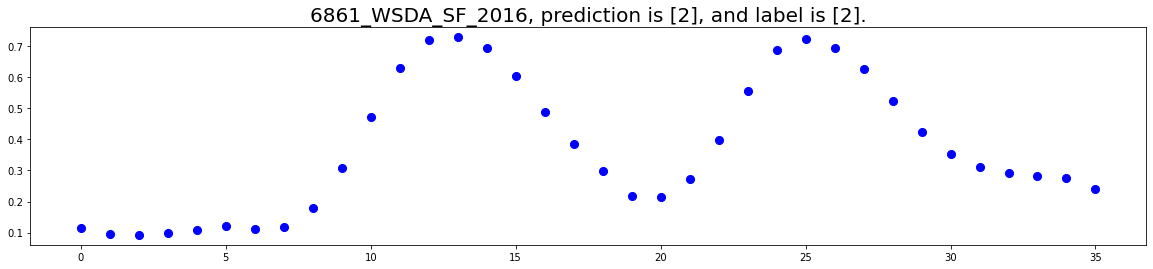

In [314]:
# Returns a NumPy Array
# Predict for One Observation (image)
test_index = 0
ID = x_test_df.iloc[test_index,].ID
prediction = logisticRegr.predict(x_test_df.iloc[test_index, 1:].values.reshape(1,-1))
print ("prediction is {}.".format(prediction))

######################################################
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

plt.scatter(range(len(x_test_df.iloc[test_index, 1:])),
            x_test_df.iloc[test_index, 1:].values,
            marker='o', s=65, c='b', label=idx);

curr_V = str(y_test_df[y_test_df.ID == ID].Vote.values[0])
title = ID + ", prediction is " + str(prediction) + ", and label is [" + curr_V + "]."
plt.title(title , fontsize = 20);

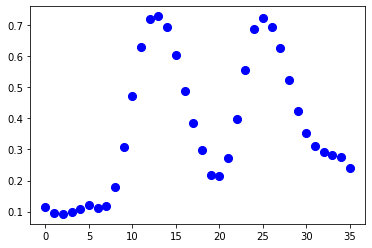

In [315]:
plt.scatter(range(len(x_test_df.iloc[test_index, 1:])),
            x_test_df.iloc[test_index, 1:].values,
            marker='o', s=65, c='b', label=idx);